# **ResNet Ablation Study**

**Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기**

**1) CIFAR-10**

In [59]:
# 데이터 셋 준비

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 데이터셋 다운로드

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 41.3MB/s]


In [5]:
# 데이터셋을 로드하고 기본 정보를 확인

image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [6]:
# 데이터의 개수 확인

train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


**2) Input Normalization**

In [7]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성

transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [8]:
# 클래스 개수

num_classes = len(trainset.classes)
print(num_classes)

10


In [9]:
# 클래스 목록

class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
# 정규화된 PyTorch 이미지 텐서를 값 범위와 차원 순서를 복원하여 시각화 가능한 이미지로 변환

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

In [11]:
# PyTorch DataLoader에서 배치 하나를 꺼내 이미지와 라벨이 올바르게 매칭되어 있는지 시각적으로 검증하는 실험·디버깅용 시각화 함수

def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

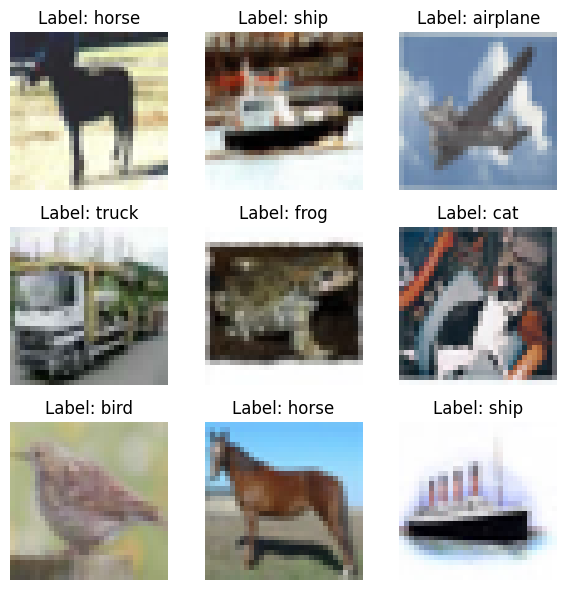

In [12]:
# 학습 데이터셋에서 9개의 이미지를 시각화

show_multiple_images(trainloader)

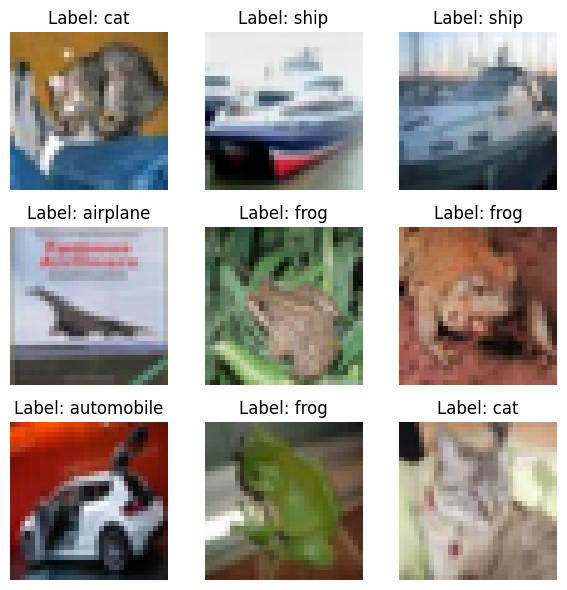

In [13]:
# 테스트 데이터셋에서 9개의 이미지를 시각화

show_multiple_images(testloader)

**Ablation Study 실습 (2) 블록 구성하기**

In [14]:
# VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 구성
# CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있음
# 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있음
# 블록에 따라서 CNN 레이어의 개수 또한 변동
# 블록의 마지막에는 항상 Max Pooling 레이어가 붙음
# 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 함


# function for building VGG Block

def build_vgg_block(input_layer,            # input_shape은 summery를 출력하기 위해서 삽입
                    num_cnn=3,
                    channel=64,
                    block_num=1):           # block_num은 레이어의 이름
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [15]:
# 케라스의 Model 클래스에서 input과 output을 정의

# 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 input_layer 에 추가
# 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 (32,32,3)이 됨
# 입력 레이어를 인자로 받아 build_vgg_block() 는 블록의 레이어를 build하고 출력값을 얻을 수 있음

class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [16]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


**Ablation Study 실습 (3) VGG Complete Model**

**1) VGG-16**

In [17]:
# VGG 모델 자체를 생성하는 클래스

# 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라짐
# VGG-16과 VGG-19에 따라서 같이 변화되므로 함수에 전달
# 각 블록 별 CNN의 수와 채널을 리스트로 전달

class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [18]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됨

vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

**2) VGG-19**

In [19]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달
# 구성만 변경하면 VGG-19를 생성 가능

vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [20]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.

def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [21]:
vgg_13 = build_vgg13()
print(vgg_13)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

**Ablation Study 실습 (4) VGG-16 vs VGG-19**

In [22]:
# Batch siza와 EPOCH 설정에 따라 학습시간 변동

BATCH_SIZE = 265
EPOCH = 15

In [23]:
# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
# VGG-16 모델을 만들고 훈련

import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []

for epoch in range(EPOCH):
    vgg_16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}")
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 114MB/s] 


[1,   100] loss: 2.912
Epoch 1: Train Accuracy: 38.80%
Epoch 1: Validation Accuracy: 64.62%
[2,   100] loss: 0.908
Epoch 2: Train Accuracy: 70.37%
Epoch 2: Validation Accuracy: 74.22%
[3,   100] loss: 0.654
Epoch 3: Train Accuracy: 78.32%
Epoch 3: Validation Accuracy: 78.95%
[4,   100] loss: 0.536
Epoch 4: Train Accuracy: 81.98%
Epoch 4: Validation Accuracy: 81.02%
[5,   100] loss: 0.460
Epoch 5: Train Accuracy: 84.54%
Epoch 5: Validation Accuracy: 81.76%
[6,   100] loss: 0.394
Epoch 6: Train Accuracy: 86.59%
Epoch 6: Validation Accuracy: 82.70%
[7,   100] loss: 0.332
Epoch 7: Train Accuracy: 88.58%
Epoch 7: Validation Accuracy: 83.66%
[8,   100] loss: 0.303
Epoch 8: Train Accuracy: 89.76%
Epoch 8: Validation Accuracy: 84.10%
[9,   100] loss: 0.255
Epoch 9: Train Accuracy: 91.14%
Epoch 9: Validation Accuracy: 84.35%
[10,   100] loss: 0.211
Epoch 10: Train Accuracy: 92.59%
Epoch 10: Validation Accuracy: 83.49%
[11,   100] loss: 0.189
Epoch 11: Train Accuracy: 93.67%
Epoch 11: Validation

In [25]:
# VGG-19 모델을 만들고 훈련

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}")

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 73.5MB/s]


[1,   100] loss: 2.679
Epoch 1: Train Accuracy: 41.59%
Epoch 1: Validation Accuracy: 66.83%
[2,   100] loss: 0.869
Epoch 2: Train Accuracy: 72.49%
Epoch 2: Validation Accuracy: 78.07%
[3,   100] loss: 0.606
Epoch 3: Train Accuracy: 80.27%
Epoch 3: Validation Accuracy: 81.34%
[4,   100] loss: 0.495
Epoch 4: Train Accuracy: 83.59%
Epoch 4: Validation Accuracy: 82.30%
[5,   100] loss: 0.436
Epoch 5: Train Accuracy: 85.83%
Epoch 5: Validation Accuracy: 83.46%
[6,   100] loss: 0.369
Epoch 6: Train Accuracy: 87.60%
Epoch 6: Validation Accuracy: 84.30%
[7,   100] loss: 0.322
Epoch 7: Train Accuracy: 89.19%
Epoch 7: Validation Accuracy: 84.60%
[8,   100] loss: 0.285
Epoch 8: Train Accuracy: 90.46%
Epoch 8: Validation Accuracy: 85.70%
[9,   100] loss: 0.238
Epoch 9: Train Accuracy: 92.00%
Epoch 9: Validation Accuracy: 85.42%
[10,   100] loss: 0.212
Epoch 10: Train Accuracy: 93.12%
Epoch 10: Validation Accuracy: 86.29%
[11,   100] loss: 0.175
Epoch 11: Train Accuracy: 94.14%
Epoch 11: Validation

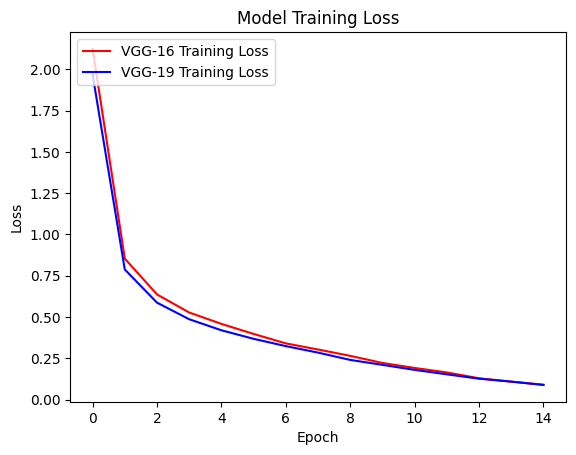

In [26]:
# 훈련 손실(Traning loss) 비교

import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

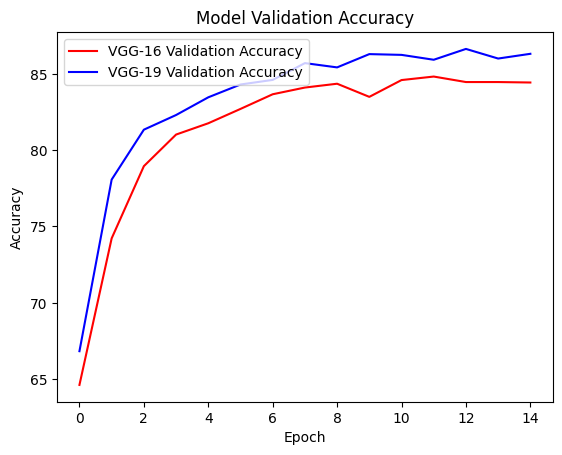

In [27]:
# 검증 정확도(Validation accuracy) 비교

plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**프로젝트: ResNet Ablation Study**

**1) ResNet 기본 블록 구성하기**

ResNet 34와 50에서 사용된 블록들의 공통점과 차이점

*   ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있음
*    ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됨

참고

*   Deep Residual Learning for Image Recognition(paper)(https://arxiv.org/pdf/1512.03385)
*   빛과 같은 카이밍허님의 깃허브(https://github.com/KaimingHe/deep-residual-networks)





**2) ResNet-34, ResNet-50 Complete Model**

In [29]:
# 기본 환경

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


In [31]:
# Residual Block 정의

# ResNet-34는 Basic block 기반의 모델임

def basic_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # projection shortcut
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


In [32]:
# Residual Block 정의

# ResNet-50은 Bottleneck block 기반의 모델임

def bottleneck_block(x, filters, stride=1):
    shortcut = x

    # 1x1 (reduce)
    x = layers.Conv2D(filters, 1, strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1x1 (expand)
    x = layers.Conv2D(filters * 4, 1, strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # projection shortcut
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


In [33]:
# Stage 구성 함수

# ResNet은 실제로 Block이 아닌 Stage를 반복(Stem → [Stage2] → [Stage3] → [Stage4] → [Stage5] → Head)

def make_stage(x, block_fn, filters, blocks, first_stride):    # def 함수(베이직 또는 보틀넥, Stage  채널 크기, stage 깊이, 다운샘플링 시점)
    x = block_fn(x, filters, stride=first_stride)
    for _ in range(1, blocks):
        x = block_fn(x, filters, stride=1)
    return x


In [35]:
# ResNet Configuration 정의

# Configuration 변경으로 모델 변경이 수월하도록 Configuration 분리

RESNET_CONFIGS = {
    "resnet18":  {"block": "basic",      "layers": [2, 2, 2, 2]},
    "resnet34":  {"block": "basic",      "layers": [3, 4, 6, 3]},
    "resnet50":  {"block": "bottleneck", "layers": [3, 4, 6, 3]},
    "resnet101": {"block": "bottleneck", "layers": [3, 4, 23, 3]},
    "resnet152": {"block": "bottleneck", "layers": [3, 8, 36, 3]},
}

In [39]:
# 통합 생성 함수

# 모델 생성과 설계를 분리하여 Configuration를 읽어서 build_resnet()을 통해 조합 가능

def build_resnet(
    version="resnet34",
    input_shape=(224, 224, 3),
    num_classes=1000
):
    assert version in RESNET_CONFIGS,

    config = RESNET_CONFIGS[version]
    block_type = config["block"]
    layers_per_stage = config["layers"]

    block_fn = basic_block if block_type == "basic" else bottleneck_block

    inputs = Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stages
    filters_list = [64, 128, 256, 512]
    for i, (filters, blocks) in enumerate(zip(filters_list, layers_per_stage)):
        stride = 1 if i == 0 else 2
        x = make_stage(x, block_fn, filters, blocks, stride)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs, name=version)


In [38]:
# ResNet-34 Complete Model

resnet_34 = build_resnet("resnet34")
resnet_34.summary()


Model: "resnet34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 112, 112,  │      9,408 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 56, 56,    │     36,864 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_36[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0] 

 Total params: 21,814,696 (83.22 MB)

 Trainable params: 21,797,672 (83.15 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [40]:
# ResNet-50 Complete Model

resnet_50 = build_resnet("resnet50")
resnet_50.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 112, 112,  │      9,408 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_66 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ re_lu_66[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 56, 56,    │      4,096 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_73[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_67 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 56, 56,    │     36,864 │ re_lu_67[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_68 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 56, 56,    │     16,384 │ re_lu_68[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 56, 56,    │     16,384 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 56, 56,    │          0 │ add_32[0][0]    

 Total params: 25,610,152 (97.69 MB)

 Trainable params: 25,557,032 (97.49 MB)

 Non-trainable params: 53,120 (207.50 KB)

**3) 일반 네트워크(plain network) 만들기**

*   ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요
*   ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가
*  skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet() 생성
*  입력 이미지의 크기는 (224, 224, 3)으로 설정



In [41]:
# Skip ON/OFF가 가능한 Basic block 구현(ResNet-34와 PlainNet-34 공용)

def basic_block(x, filters, stride=1, use_skip=True):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if use_skip:
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([x, shortcut])

    x = layers.ReLU()(x)
    return x


In [42]:
# Skip ON/OFF가 가능한 Basic block 구현(ResNet-50과 PlainNet-50 공용)

def bottleneck_block(x, filters, stride=1, use_skip=True):
    shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters * 4, 1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if use_skip:
        if stride != 1 or shortcut.shape[-1] != filters * 4:
            shortcut = layers.Conv2D(filters * 4, 1, strides=stride, use_bias=False)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([x, shortcut])

    x = layers.ReLU()(x)
    return x


In [45]:
# Stage 함수 수정(Skip connection 옵션 추가)

def make_stage(x, block_fn, filters, blocks, first_stride, use_skip):
    x = block_fn(x, filters, stride=first_stride, use_skip=use_skip)
    for _ in range(1, blocks):
        x = block_fn(x, filters, stride=1, use_skip=use_skip)
    return x


In [49]:
# skip connection을 ON한 build_plainnet() 함수

def build_resnet(version="resnet34", input_shape=(224,224,3), num_classes=1000):
    config = RESNET_CONFIGS[version]
    block_fn = basic_block if config["block"] == "basic" else bottleneck_block

    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for i, (filters, blocks) in enumerate(zip([64,128,256,512], config["layers"])):
        stride = 1 if i == 0 else 2
        x = make_stage(x, block_fn, filters, blocks, stride, use_skip=True)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs, name=version)


In [50]:
# skip connection을 OFF한 build_plainnet() 함수

def build_plainnet(version="resnet34", input_shape=(224,224,3), num_classes=1000):
    config = RESNET_CONFIGS[version]
    block_fn = basic_block if config["block"] == "basic" else bottleneck_block

    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for i, (filters, blocks) in enumerate(zip([64,128,256,512], config["layers"])):
        stride = 1 if i == 0 else 2
        x = make_stage(x, block_fn, filters, blocks, stride, use_skip=False)   # use_skip=False시 OFF

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs, name=f"plain_{version}")


In [51]:
# 모델 생성

resnet34     = build_resnet("resnet34")
resnet50     = build_resnet("resnet50")
plainnet34   = build_plainnet("resnet34")
plainnet50   = build_plainnet("resnet50")

In [52]:
# 수정된 Complete Model

resnet34.summary()
resnet50.summary()
plainnet34.summary()
plainnet50.summary()


Model: "resnet34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_217 (Conv2D) │ (None, 112, 112,  │      9,408 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_217[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_200 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56,    │          0 │ re_lu_200[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_218 (Conv2D) │ (None, 56, 56,    │     36,864 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_218[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_201 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_219 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_201[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_219[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_202 (ReLU)    │ (None, 56, 56,    │          0 │ add_80[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_220 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_202[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_220[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_203 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_221 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_203[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_221[0][0]

 Total params: 21,814,696 (83.22 MB)

 Trainable params: 21,797,672 (83.15 MB)

 Non-trainable params: 17,024 (66.50 KB)

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_253 (Conv2D) │ (None, 112, 112,  │      9,408 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_253[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_233 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ re_lu_233[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_254 (Conv2D) │ (None, 56, 56,    │      4,096 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_254[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_234 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_255 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_234[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_255[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_235 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_256 (Conv2D) │ (None, 56, 56,    │     16,384 │ re_lu_235[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_257 (Conv2D) │ (None, 56, 56,    │     16,384 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_256[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_257[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_96 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_236 (ReLU)    │ (None, 56, 56,    │          0 │ add_96[0][0]    

 Total params: 25,610,152 (97.69 MB)

 Trainable params: 25,557,032 (97.49 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "plain_resnet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_306 (Conv2D)             │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_306         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_282 (ReLU)                │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_307 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_307         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_283 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_308 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_308         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_284 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_309 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_309         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_285 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_310 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_310         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_286 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_311 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_311         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_287 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_312 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_312         │ (None, 56, 56, 64)     │           25

 Total params: 21,639,080 (82.55 MB)

 Trainable params: 21,623,848 (82.49 MB)

 Non-trainable params: 15,232 (59.50 KB)

Model: "plain_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_339 (Conv2D)             │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_339         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_315 (ReLU)                │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_340 (Conv2D)             │ (None, 56, 56, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_340         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_316 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_341 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_341         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_317 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_342 (Conv2D)             │ (None, 56, 56, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_342         │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_318 (ReLU)                │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_343 (Conv2D)             │ (None, 56, 56, 64)     │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_343         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_319 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_344 (Conv2D)             │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_344         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_320 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_345 (Conv2D)             │ (None, 56, 56, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_345         │ (None, 56, 56, 256)    │         1,02

 Total params: 22,825,896 (87.07 MB)

 Trainable params: 22,780,456 (86.90 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [53]:
# Add 레이어 존재 여부 확인 검증

# ResNet에는 Add 레이어가 있고, PlainNet에는 없어야 함
# Skip Connection이 정확히 OFF되었는지 검증

def count_add_layers(model):
    return sum(1 for layer in model.layers if layer.__class__.__name__ == "Add")

print("ResNet-34 Add:", count_add_layers(resnet34))
print("PlainNet-34 Add:", count_add_layers(plainnet34))
print("ResNet-50 Add:", count_add_layers(resnet50))
print("PlainNet-50 Add:", count_add_layers(plainnet50))

ResNet-34 Add: 16
PlainNet-34 Add: 0
ResNet-50 Add: 16
PlainNet-50 Add: 0


In [54]:
# 레이어 수 및 파라미터 수 비교 검증

# ResNet-34와 PlainNet-34 또는 ResNet-50와 PlainNet-50의 파라미터 수가 거의 일치

for model in [resnet34, plainnet34, resnet50, plainnet50]:
    print(f"{model.name:15s} | Params: {model.count_params():,}")

resnet34        | Params: 21,814,696
plain_resnet34  | Params: 21,639,080
resnet50        | Params: 25,610,152
plain_resnet50  | Params: 22,825,896


In [55]:
from tensorflow.keras.utils import plot_model


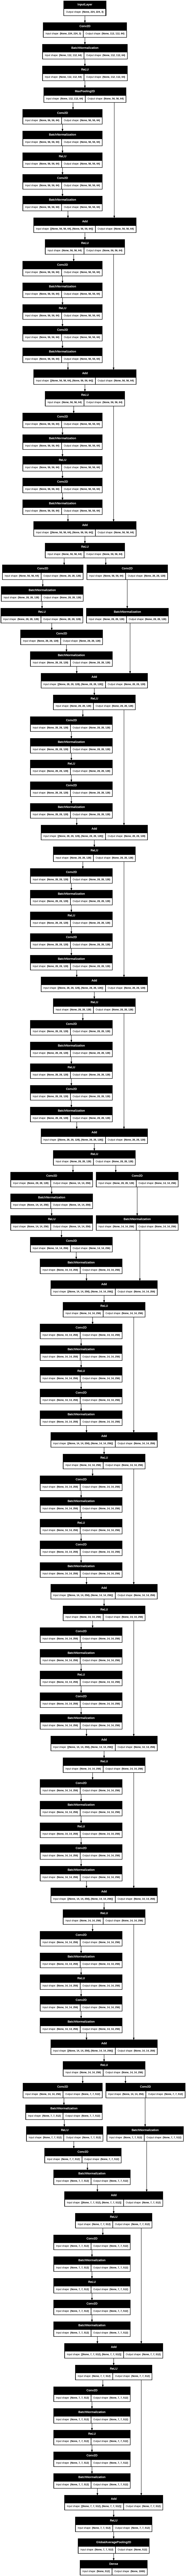

In [56]:
# 모델 시각화 검증(ResNet34와 PlainNet34 검증)

# ResNet의 경우 Merge(병렬 경로)가 보이는 반면에, PlainNet은 단일 직렬 구조 형태

plot_model(
    resnet34,
    show_shapes=True,
    show_layer_names=False,
    dpi=120
)

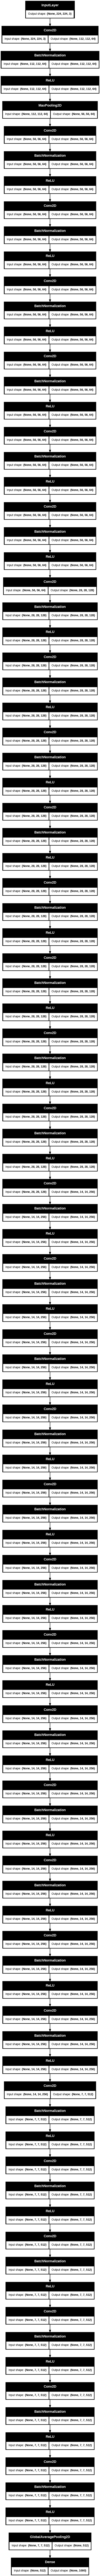

In [57]:
plot_model(
    plainnet34,
    show_shapes=True,
    show_layer_names=False,
    dpi=120
)


In [58]:
# 출력 shape 동일 여부를 통한 비교 검증

import tensorflow as tf

x = tf.random.normal((1, 224, 224, 3))

print(resnet34(x).shape)
print(plainnet34(x).shape)


(1, 1000)
(1, 1000)


**4) ResNet-50 vs PlainNet-50 또는 ResNet-34 vs PlainNet-34**

In [60]:
# 환경 설정

device = torch.device("cuda" if torch.cuda.is_available() else "gpu")

In [61]:
# Oxford-IIIT Pet Dataset 로딩

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(               # Nonermalize : ResNet 구조 + ImageNet 스타일 전처리
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Dataset 및 DataLoader
dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=True,
    transform=transform
)

num_classes = 37                                # 고양이·강아지 37개 품종 분류
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 792M/792M [00:36<00:00, 22.0MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.7MB/s]


In [63]:
# Basic block 정의

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Identity()
        if use_skip and (stride != 1 or in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.use_skip:
            out += self.shortcut(x)

        return torch.relu(out)


In [64]:
# Bottleneck block 정의

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.shortcut = nn.Identity()
        if use_skip and (stride != 1 or in_channels != out_channels * 4):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.use_skip:
            out += self.shortcut(x)

        return torch.relu(out)


In [65]:
# ResNet 및 PlainNet 통합 생성

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=37, use_skip=True):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(block, 64, layers[0], 1, use_skip)
        self.layer2 = self._make_layer(block, 128, layers[1], 2, use_skip)
        self.layer3 = self._make_layer(block, 256, layers[2], 2, use_skip)
        self.layer4 = self._make_layer(block, 512, layers[3], 2, use_skip)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride, use_skip):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, use_skip))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, 1, use_skip))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [67]:
# 모델 생성

resnet34   = ResNet(BasicBlock, [3,4,6,3], use_skip=True).to(device)
plain34    = ResNet(BasicBlock, [3,4,6,3], use_skip=False).to(device)

resnet50   = ResNet(Bottleneck, [3,4,6,3], use_skip=True).to(device)
plain50    = ResNet(Bottleneck, [3,4,6,3], use_skip=False).to(device)


In [68]:
# 학습 및 검증

def train_model(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {"val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
                _, preds = outputs.max(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(correct / total)

        print(f"Epoch {epoch+1}: val_acc={history['val_acc'][-1]:.4f}")

    return history              # 학습을 통해 만들어진 history 저장


In [73]:
# Batch siza와 EPOCH 설정에 따라 학습시간 변동

BATCH_SIZE = 32
EPOCH = 10

In [74]:
# 학습 실행

histories = {
    "ResNet-34": train_model(resnet34),
    "Plain-34":  train_model(plain34),
    "ResNet-50": train_model(resnet50),
    "Plain-50":  train_model(plain50),
}


Epoch 1: val_acc=0.2188


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2: val_acc=0.1739
Epoch 3: val_acc=0.2038
Epoch 4: val_acc=0.1970


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5: val_acc=0.2541


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 1: val_acc=0.1114


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2: val_acc=0.1128


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3: val_acc=0.1155


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4: val_acc=0.1114


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^
    AssertionErrorif 

Epoch 5: val_acc=0.1264


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   ^^^ ^   ^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 1: val_acc=0.0598


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee91c3c5ee0>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process' 
             ^ ^^ ^ ^^ ^^^^^^^^^^^^
^  Fil

Epoch 2: val_acc=0.1033
Epoch 3: val_acc=0.1345
Epoch 4: val_acc=0.1182
Epoch 5: val_acc=0.1671
Epoch 1: val_acc=0.0380
Epoch 2: val_acc=0.0639
Epoch 3: val_acc=0.0489
Epoch 4: val_acc=0.0462
Epoch 5: val_acc=0.0557


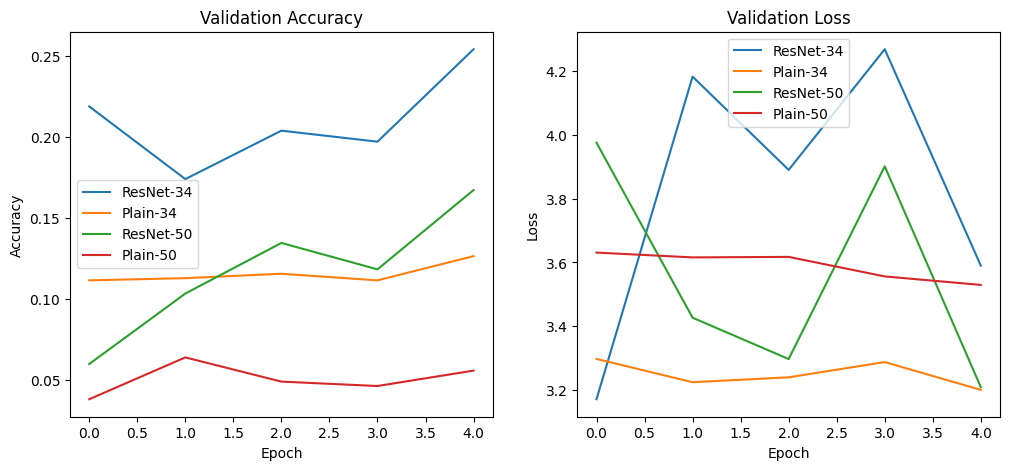

In [75]:
# Validation Accuracy(검증 정확도)와 Validation Loss(검증 손실) 시각화

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
for name, h in histories.items():
    plt.plot(h["val_acc"], label=name)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
for name, h in histories.items():
    plt.plot(h["val_loss"], label=name)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [77]:
# Ablation Study 결과표(residual모델과 plain모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준)

import pandas as pd

rows = []
for name, h in histories.items():
    rows.append({
        "Model": name,
        "Depth": 34 if "34" in name else 50,
        "Skip Connection": "Yes" if "ResNet" in name else "No",
        "Best Val Accuracy (%)": max(h["val_acc"]) * 100
    })

ablation_df = pd.DataFrame(rows)
ablation_df


Model  Depth Skip Connection  Best Val Accuracy (%)
0  ResNet-34     34             Yes              25.407609
1   Plain-34     34              No              12.635870
2  ResNet-50     50             Yes              16.711957
3   Plain-50     50              No               6.385870

# 최종 보고서

* 실험설정   
  *   데이터셋 : Oxford-IIIT Pet (37 classes)
  *   대상모델 : ResNet-34, ResNet-50, PlainNet-34, PlainNet-50
  *   차이점 : skip connection 유무
  *   훈련조건 : 동일 epoch, 동일 optimizer, 동일 데이터 분할

* Validation Accuracy 결과    
  *   ResNet-34와 ResNet-50 모델은 Epoch가 증가할 수록 정확성이 전반적으로 상승
  *   PlainNet-34와 PlainNet-50 모델은 추이가 완만하여 학습이 되지 않는 것으로 판단
  *   Skip connection의 유무에 따라 학습이 가능하다는 것으로 해석

* Validation Loss 결과  
  *   torchvision에서 제공하는 데이터셋으로 학습 진행 시 Loss가 감소하는 구간 존재하지만 모든 모델에서 동일하게 나타나지 않음
  *   ResNet-34 모델에서 가장 명확히 나타났고 feature를 실제로 안정적으로 학습하고 있다고 해석 가능
  *   Plainnet-50은 Loss의 감소가 거의 없으므로 모델의 학습이 제대로 이루어 지지 않고 있음을 예측(degradation problem 현상 발생)

* Ablation Study 결과
  *   Skip Connection OFF시(PlainNet 모델) 정확도 가 절반 이하로 감소함을 확인
  *   모델의 Depth가 깊어질 수록 PlainNet의 성능 급락


# 회고


*   Residual 모델과 Plain 모델의 유사점과 차이점을 이해할 수 있었고 실제 구현해보는 좋은 기회였음
*   Residual 모델은 실제적인 탐지나 분류 문제를 해결하는데 활용성이 더 PlainNet 모델보다 많다고 판단됨
*   이번 학습의 목적이 모델의 최적 성능 구현이 아니라 모델의 Loss 감소 파악, 학습 안정성, 정확성 측면에서의 상대적 차이를 확인하는 것이어서 최적의 모델 성능 구현은 조금 더 학습이 필요함

